In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
import random
import pandas as pd

from PIL import Image
import torch
from torch.utils.data import Dataset

# !pip install efficientnet_pytorch
#from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
path2csv = './cards.csv'
df = pd.read_csv(path2csv)
df.tail()

,class index,filepaths,labels,card type,data set
8149,52,valid/two of spades/1.jpg,two of spades,two,valid
8150,52,valid/two of spades/2.jpg,two of spades,two,valid
8151,52,valid/two of spades/3.jpg,two of spades,two,valid
8152,52,valid/two of spades/4.jpg,two of spades,two,valid
8153,52,valid/two of spades/5.jpg,two of spades,two,valid


In [4]:
df['class index'].value_counts()

3     191
19    182
2     181
16    181
18    178
36    175
30    173
32    172
29    171
17    170
5     169
44    168
40    168
11    168
12    167
52    165
51    165
14    164
28    164
46    163
6     162
37    162
42    161
24    161
8     160
35    153
48    152
41    151
15    150
31    149
38    149
9     148
4     148
10    146
22    145
7     145
27    143
50    143
49    140
43    139
26    139
1     139
21    138
39    137
45    136
23    135
34    134
25    134
0     130
20    125
13    124
47    123
33    118
Name: class index, dtype: int64

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.metadata.iloc[idx, 1]
        if not os.path.isfile(img_name):
            print(img_name, idx)
        image = Image.open(img_name)
        label = self.metadata.iloc[idx, 0]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [6]:
im_size = 224
train_dataset = CustomDataset(df,transform=transforms.Compose([
                                               transforms.Resize(im_size),
                                                transforms.RandomRotation(45),
                                               transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                           ]))

In [7]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, 
                                             shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


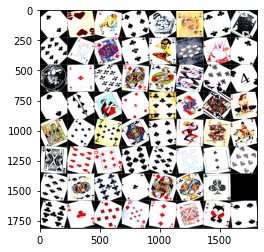

tensor([49, 51, 51, 40, 50, 32, 12, 16, 25, 49, 22, 45, 25, 28, 14, 49, 45,  1,
        41, 30, 16, 34, 36, 15, 52, 48, 32,  9, 33, 32, 19, 42, 16, 36, 36, 29,
        40, 20, 22,  7, 23, 43, 38, 28, 28, 43, 48,  7,  7, 19, 25,  0, 30, 21,
         0, 15, 25, 12,  5,  5, 46, 17, 47, 15])


In [8]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)

images, features = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(features)


In [9]:
import torchvision.models as models
model = models.resnet18(pretrained = True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, df['class index'].nunique())

model = model.to(device)

In [10]:
num_epochs = 20
learning_rate = 0.001
loss_func = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer=opt,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [12]:
def train(model, train_loader, optimizer, log_interval):
#    for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    run_cnt = 0
#    for data in tqdm(train_loader):
    for i, data in enumerate(train_loader):
        num_of_mini_batch = len(train_loader)
        inputs, gt = data
        inputs, gt = inputs.to(device), gt.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
#        print(gt.shape)
#        print(preds.shape)

        loss = loss_func(outputs, gt)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == gt.data)
        run_cnt += len(gt)
        
        if i % log_interval == 0:
            print("[{}/{}]({:.0f}%)   Train Loss : {:.6f} ".format(i*batch_size, 
                                                               len(train_loader.dataset),
                                                               100.*i / num_of_mini_batch,
                                                               loss.item()))
            #torch.save(model.state_dict(), './my_weights.pth')
        
    cost = running_loss / len(train_loader)
    acc = (running_corrects.double() / run_cnt)*100
    train_loss_list.append(cost)
    train_acc_list.append(acc)
    
    print('train loss: %.4f, train acc: %.4f' %(cost, acc))
    torch.save(model.state_dict(), './new_weights.pth')

In [13]:
train_loss_list = []
train_acc_list = []

for i in range(num_epochs):
    print("==================== EPOCH :  %d ===================="%i)
    #print('='*20,'EPOCH : ', i,'='*20)
    #print('-'*20,'TRAIN','-'*20)
    train(model, train_loader, opt, log_interval = 12)
    #print('-'*20,'TEST','-'*20)
#    test(model, test_loader, opt, logger)
    scheduler.step()

==================== EPOCH :  0 ====================
[0/8154](0%)   Train Loss : 4.089381 
[768/8154](9%)   Train Loss : 2.999323 
[1536/8154](19%)   Train Loss : 2.570936 
[2304/8154](28%)   Train Loss : 2.817338 
[3072/8154](38%)   Train Loss : 1.873548 
[3840/8154](47%)   Train Loss : 1.909576 
[4608/8154](56%)   Train Loss : 1.766198 
[5376/8154](66%)   Train Loss : 1.684381 
[6144/8154](75%)   Train Loss : 1.636028 
[6912/8154](84%)   Train Loss : 1.324187 
[7680/8154](94%)   Train Loss : 1.423969 
train loss: 2.0259, train acc: 42.0652
==================== EPOCH :  1 ====================
[0/8154](0%)   Train Loss : 1.547347 
[768/8154](9%)   Train Loss : 1.041037 
[1536/8154](19%)   Train Loss : 0.876494 
[2304/8154](28%)   Train Loss : 1.234035 
[3072/8154](38%)   Train Loss : 1.004165 
[3840/8154](47%)   Train Loss : 1.294094 
[4608/8154](56%)   Train Loss : 1.347606 
[5376/8154](66%)   Train Loss : 1.304331 
[6144/8154](75%)   Train Loss : 1.337330 
[6912/8154](84%)   Train Lo

==================== EPOCH :  15 ====================
[0/8154](0%)   Train Loss : 0.172596 
[768/8154](9%)   Train Loss : 0.189023 
[1536/8154](19%)   Train Loss : 0.092579 
[2304/8154](28%)   Train Loss : 0.177243 
[3072/8154](38%)   Train Loss : 0.161322 
[3840/8154](47%)   Train Loss : 0.230263 
[4608/8154](56%)   Train Loss : 0.370058 
[5376/8154](66%)   Train Loss : 0.119402 
[6144/8154](75%)   Train Loss : 0.318768 
[6912/8154](84%)   Train Loss : 0.144185 
[7680/8154](94%)   Train Loss : 0.101046 
train loss: 0.1661, train acc: 95.1803
==================== EPOCH :  16 ====================
[0/8154](0%)   Train Loss : 0.074114 
[768/8154](9%)   Train Loss : 0.037017 
[1536/8154](19%)   Train Loss : 0.240549 
[2304/8154](28%)   Train Loss : 0.094772 
[3072/8154](38%)   Train Loss : 0.115076 
[3840/8154](47%)   Train Loss : 0.085543 
[4608/8154](56%)   Train Loss : 0.151332 
[5376/8154](66%)   Train Loss : 0.061100 
[6144/8154](75%)   Train Loss : 0.199015 
[6912/8154](84%)   Train 

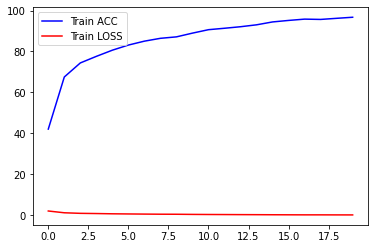

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(range(20), torch.stack(train_acc_list, dim=0).cpu().numpy(), 'b-', label='Train ACC')
ax.plot(range(20), train_loss_list, 'r', label='Train LOSS')
ax.legend()
plt.show()

## Visualization

In [63]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
import time
import copy
import random
import pandas as pd

from PIL import Image
import torch
from torch.utils.data import Dataset

# !pip install efficientnet_pytorch
#from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')


In [64]:
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

In [65]:
import pandas as pd

In [66]:
df = pd.read_csv('cards.csv')
df.head(5)

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [67]:
img_sample = df.sample(n=15, replace=False)
img_sample.reset_index(inplace=True, drop=True)
img_sample

,class index,filepaths,labels,card type,data set
0,32,test/queen of spades/3.jpg,queen of spades,queen,test
1,5,train/eight of diamonds/013.jpg,eight of diamonds,eight,train
2,49,train/two of clubs/049.jpg,two of clubs,two,train
3,7,train/eight of spades/114.jpg,eight of spades,eight,train
4,34,train/seven of diamonds/072.jpg,seven of diamonds,seven,train
5,32,train/queen of spades/036.jpg,queen of spades,queen,train
6,36,train/seven of spades/009.jpg,seven of spades,seven,train
7,5,train/eight of diamonds/014.jpg,eight of diamonds,eight,train
8,11,train/five of spades/075.jpg,five of spades,five,train
9,9,train/five of diamonds/071.jpg,five of diamonds,five,train


In [68]:
import torchvision.models as models
model = models.resnet18(pretrained = False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, df['class index'].nunique())

In [69]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.metadata.iloc[idx, 1]
        if not os.path.isfile(img_name):
            print(img_name, idx)
        image = Image.open(img_name)
        label = self.metadata.iloc[idx, 0]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label, img_name

In [70]:
model.load_state_dict(torch.load('./new_weights.pth', map_location=torch.device('cpu')))
model.eval()
#cam_extractor = SmoothGradCAMpp(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
im_size = 224
eval_dataset = CustomDataset(img_sample,transform=transforms.Compose([
                                               transforms.Resize(im_size),
                                                transforms.RandomRotation(45, fill=0),
                                               transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                           ]))

In [72]:
batch_size = 1
eval_loader = torch.utils.data.DataLoader(eval_dataset,
                                             batch_size=batch_size, 
                                             shuffle=False)

In [73]:
indexs = []
images = []
def test(model, test_loader):
    with torch.no_grad():
        for i, data in enumerate(eval_loader):
            with torch.no_grad():
                inputs, gt, image_path = data
                inputs, gt = inputs.to(device), gt.to(device)
                
                outputs = model(inputs)
                
                _, preds = torch.max(outputs, 1)
                if gt == preds:
                    images.append(image_path[0])
                    indexs.append(i)

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [75]:
test(model, eval_loader)

In [76]:
cam_extractor = SmoothGradCAMpp(model)

[label] :  queen of spades
[class index] :  32
Prediction: True


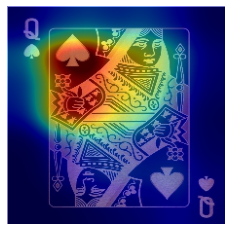

[label] :  eight of diamonds
[class index] :  5
Prediction: True


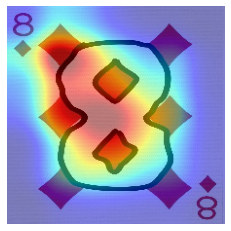

[label] :  two of clubs
[class index] :  49
Prediction: True


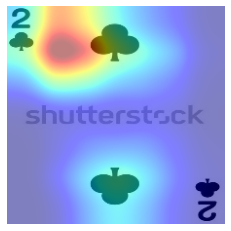

[label] :  eight of spades
[class index] :  7
Prediction: True


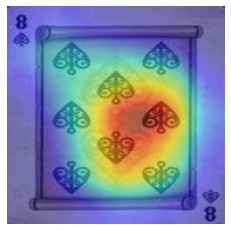

[label] :  seven of diamonds
[class index] :  34
Prediction: True


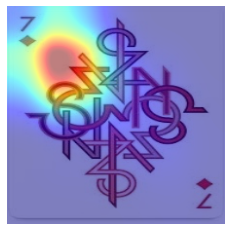

[label] :  queen of spades
[class index] :  32
Prediction: True


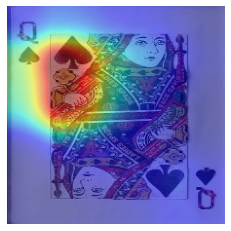

[label] :  seven of spades
[class index] :  36
Prediction: True


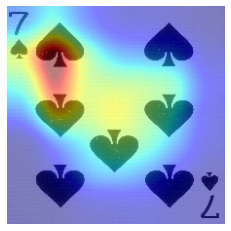

[label] :  eight of diamonds
[class index] :  5
Prediction: True


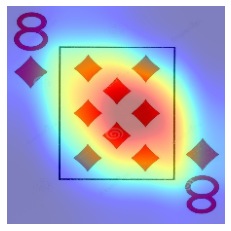

[label] :  five of spades
[class index] :  11
Prediction: True


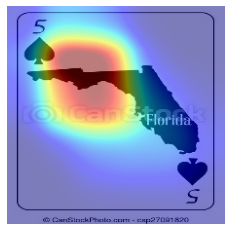

[label] :  five of diamonds
[class index] :  9
Prediction: True


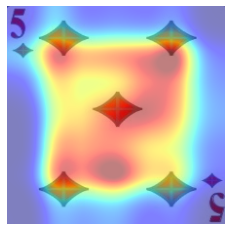

[label] :  ace of clubs
[class index] :  0
Prediction: True


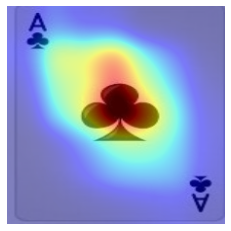

[label] :  ten of spades
[class index] :  44
Prediction: True


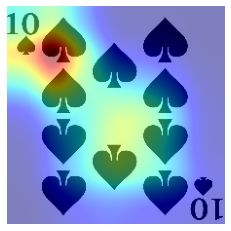

[label] :  jack of diamonds
[class index] :  17
Prediction: True


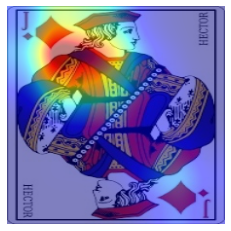

[label] :  five of clubs
[class index] :  8
Prediction: True


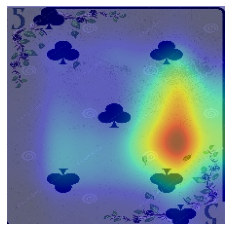

[label] :  nine of hearts
[class index] :  27
Prediction: True


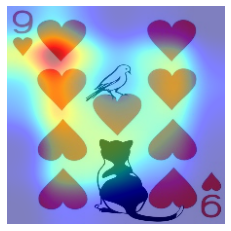

In [77]:
for i, image in enumerate(img_sample['filepaths'].tolist()):
    print("[label] : ", img_sample['labels'][i])
    print("[class index] : ", img_sample['class index'][i])
    if image in images:
        print("Prediction: True")
    else:
        print("Prediction: False")
    img = read_image(''.join(image))
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    out = model(input_tensor.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.show()